# Using TensorFlow with Jetscape Benchmarck Dataset
**About the JETSCAPE Eloss Classification dataset**.   
Jetscape Eloss Classification is the equivalent *Hello World* of jet image analysis.
It consists of 2 categories, MATTER/MATTER+LBT, in 32x32 pixel squares.  
Each gray-scale pixel contains an integer 0-255 to indicate darkness, with 0 white and 255 black.  
There are about 180,000 training records, and about 20,000 test records.  
In other words, the images of numbers have already been transformed into arrays of ints to make them easier to use for ML projects. You can find more info on the jetscape [here](https://jetscape.org/). You can also download it from [here](#).


## Part 0: Prerequisites:

We recommend that you run this this notebook in the cloud on Google Colab (see link with icon at the top) if you're not already doing so. It's the simplest way to get started. You can also [install TensorFlow locally](https://www.tensorflow.org/install/).

Note that there's [tf.keras](https://www.tensorflow.org/guide/keras) (comes with TensorFlow) and there's [Keras](https://keras.io/) (standalone). You should be using [tf.keras](https://www.tensorflow.org/guide/keras) because (1) it comes with TensorFlow so you don't need to install anything extra and (2) it comes with powerful TensorFlow-specific features.

In [ ]:
print('Loading/Installing Package => Begin\n\n')
# Commonly used modules
import numpy as np
import os
from os import path, makedirs
import time
from time import time
import subprocess
import sys


def install(package):
  print("Installing "+package) 
  subprocess.check_call([sys.executable,"-m" ,"pip", "install", package])
  print("Installed "+package+"\n") 
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import load_model

# !pip3 install sklearn
install("sklearn")
from sklearn.metrics import confusion_matrix, classification_report

# !pip3 install seaborn
install("seaborn")
import seaborn as sns


# Images, plots, display, and visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

#reading/writing into files
# !pip3 install pickle5
install("pickle5")
import pickle5 as pickle


#import cv2
install("IPython")
import IPython
from six.moves import urllib


print('\n########################################################################')
print('Checking the running platforms\n')
import platform
running_os=platform.system()
print("OS: "+running_os)
print("OS version: "+platform.release())

try:
  from google.colab import drive
  COLAB = True
except:
  COLAB = False
print("running on Colab: "+str(COLAB))


print("Python version: "+platform.python_version())
print("Tensorflow version: "+tf.__version__)

dataset_directory_path=''
simulation_directory_path=''

if COLAB == True:
  drive.mount('/content/drive')
  dataset_directory_path='/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/'
  simulation_directory_path=dataset_directory_path+'simulation-results-cnn-01-1200K-config-05-02/'
elif 'Linux' in running_os:
  dataset_directory_path='/wsu/home/gy/gy40/gy4065/hm.jetscapeml.data/simulation_results/'
  simulation_directory_path=dataset_directory_path+'simulation-results-cnn-01-1200K-config-05-02/'
else:
  dataset_directory_path= 'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.data\\simulation_results\\'
  simulation_directory_path=dataset_directory_path+'simulation-results-cnn-01-1200K-config-05-02\\'
print('Dataset Directory Path: '+dataset_directory_path)

# dataset_file_name='jetscape-ml-benchmark-dataset-2k-randomized.pkl'
# dataset_file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-2k-shuffled.pkl'
# dataset_file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-200k-shuffled-01.pkl'
# dataset_file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-1200k-momentum-shuffled.pkl'
# dataset_file_name='config-01-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
# dataset_file_name='config-02-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
# dataset_file_name='config-03-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
# dataset_file_name='config-04-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
dataset_file_name='config-05-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
# dataset_file_name='config-06-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
# dataset_file_name='config-07-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
# dataset_file_name='config-08-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
# dataset_file_name='config-09-matter-vs-lbt-simulationsize1200000-dataset-momentum-shuffled.pkl'
print("Dataset file name: "+dataset_file_name)

if not path.exists(simulation_directory_path):
    makedirs(simulation_directory_path)
print('Simulation Results Path: '+simulation_directory_path)
print('########################################################################\n')
print('\nLoading/Installing Package => End\n\n')

## 1. Load Data into a Numpy Array  
I downloaded the data file onto my desktop and loaded it locally.  
You can also load it directly from the cloud as follows:  
```mnist = tf.keras.datasets.mnist  
(x_train, y_train), (x_test, y_test) = jetscapeMl.load_data()  
```  
**After the load:**   
x_train contains 180k arrays of 32x32.  
The y_train vector contains the corresponding labels for these.  
x_test contains 20k arrays of 32x32.  
The y_test vector contains the corresponding labels for these.

#Saving and Loading Dataset Methods Implementation

In [2]:
def save_dataset(file_name,dataset):
    with open(file_name, 'wb') as dataset_file:
        pickle.dump(dataset,dataset_file, protocol=pickle.HIGHEST_PROTOCOL)

        
def load_dataset(file_name):
    with open(file_name, 'rb') as dataset_file:
        (x_train, y_train), (x_test, y_test) = pickle.load(dataset_file, encoding='latin1')
        dataset=((x_train, y_train), (x_test, y_test))
        return dataset

## 2. Use Matplotlib to visualize one record.  
I set the colormap to Grey and ColorMap. There are a bunch of other colormap choices if you like bright visualizations. Try magma or any of the other  choice in the [docs](https://matplotlib.org/tutorials/colors/colormaps.html).

In [ ]:
def plot_event(image_frame_size,event_matrix,file_name):
  plt.imshow(event_matrix.reshape(image_frame_size, image_frame_size), cmap=cm.Greys)
  cb = plt.colorbar()
  cb.set_label("Hit Frequency")
  
  file_path=simulation_directory_path+file_name
  plt.savefig(file_path)
# # Funtionality Testing
# # Plotting sample Random Event Histogram on gray scale
# image_frame_size=32
# plot_event(image_frame_size,counts,file_name='sample_random_event_histogram_32x32_grayscale.png')

#Loading Dataset
**First learning step**

In [3]:
class JetscapeMlCnn:
   # class attribute
  
    # Instance attribute
    def __init__(self, x_train,y_train,x_test,y_test):
        self.x_train=x_train
        self.y_train=y_train
        self.x_test=x_test
        self.y_test=y_test


#Loading Dataset Phase


dataset_file_path=dataset_directory_path+dataset_file_name
print("Dataset file path: "+dataset_file_path)
(x_train, y_train), (x_test, y_test) =load_dataset(dataset_file_path)

oJetscapeMlCnn=JetscapeMlCnn(x_train, y_train, x_test, y_test)
print("\n#############################################################")
print("Post-Load: DataType Checkpoint: Begin")
print(type(oJetscapeMlCnn.x_train), oJetscapeMlCnn.x_train.size, oJetscapeMlCnn.x_train.shape)
print(type(oJetscapeMlCnn.y_train), oJetscapeMlCnn.y_train.size, oJetscapeMlCnn.y_train.shape)
print(type(oJetscapeMlCnn.x_test), oJetscapeMlCnn.x_test.size, oJetscapeMlCnn.x_test.shape)
print(type(oJetscapeMlCnn.y_test), oJetscapeMlCnn.y_test.size, oJetscapeMlCnn.y_test.shape)
print(oJetscapeMlCnn.y_train[1500], oJetscapeMlCnn.y_test[99])
print(oJetscapeMlCnn.y_train[1:500])
print("Post-Load: DataType Checkpoint: End")
print("#############################################################\n")

Dataset file path: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/jetscape-ml-benchmark-dataset-matter-vs-lbt-200k-shuffled-01.pkl

#############################################################
Post-Load: DataType Checkpoint: Begin
<class 'numpy.ndarray'> 184320000 (180000, 32, 32)
<class 'numpy.ndarray'> 180000 (180000,)
<class 'numpy.ndarray'> 20480000 (20000, 32, 32)
<class 'numpy.ndarray'> 20000 (20000,)
MVAC MVAC
['MLBT' 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MVAC' 'MLBT'
 'MVAC' 'MLBT' 'MVAC' 'MVAC' 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MLBT' 'MLBT'
 'MLBT' 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MLBT' 'MLBT'
 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MLBT' 'MLBT'
 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MVAC' 'MLBT'
 'MVAC' 'MLBT' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MVAC' 'MLBT' 'MLBT' 'MLBT'
 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MLBT' 'MVAC' 'MLBT' 'MVAC' 'MVAC'
 'MVAC' 'MVAC' 'MLBT' 'MLBT' 'MVAC' 'MVAC' 'MVAC' 'MLBT' 'MLBT

## 3. Plot a bunch of records to see sample data  
Basically, use the same Matplotlib commands above in a for loop to show 20 records from the train set in a subplot figure. We also make the figsize a bit bigger and remove the tick marks for readability.
** TODO: try to make the subplot like the below from the first project meeting

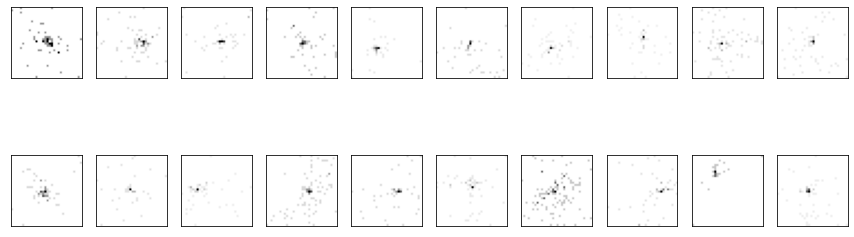

In [4]:
from matplotlib.pyplot import figure

def plot_20_sample_events(events_matrix_items):
  # images = x_train[0:18]
  # fig, axes = plt.subplots(3, 6, figsize=[9,5])
  
  images = events_matrix_items
  # fig, axes = plt.subplots(2, 10, figsize=[15,5])
  fig, axes = plt.subplots(2, 10, figsize=[40,8], dpi=100)
  for i, ax in enumerate(axes.flat):
      # current_plot= ax.imshow(x_train[i].reshape(32, 32), cmap=cm.Greys, extent=[-3.14, 3.14, -3.14, 3.14])
      current_plot= ax.imshow(x_train[i].reshape(32, 32), cmap=cm.jet,vmin=0, vmax=3)
      ticks = np.linspace(0, 31, endpoint=True)
      # ax.set_xticks( [0, 31, 5])  
      # ax.set_yticks( ticks) 
      # ax.set_xticks( [-3.14, 3.14, 0.5],  [-3.14, 3.14, 0.5] )  
      # ax.set_yticks( [-3.14, 3.14, 0.5],  [-3.14, 3.14, 0.5] )  
      ax.set_xticks([])
      ax.set_yticks([]) 
      
      # 
  

 
  
  # fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
  #                   wspace=0.02, hspace=0.02)

  

  
  # cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
  # cbar = fig.colorbar(current_plot, cax=cb_ax)
  cbar=fig.colorbar(current_plot, ax=axes.ravel().tolist())
  # set the colorbar ticks and tick labels
  
  # ticks = np.linspace(current_plot.min(), current_plot.max(), 5, endpoint=True)
  # cbar.set_ticks(ticks)
  # cbar.set_ticklabels(['low', 'medium', 'high'])

  file_name='hm_jetscape_ml_plot_20_sample_events.png'
  file_path=simulation_directory_path+file_name
  plt.savefig(file_path)

  plt.show()
  plt.close()
#Plotting 20 Sample Events Phase  from shuffled dataset
events_matrix_items=np.array(np.zeros((20,32,32)))
events_matrix_items=x_train[0:20]

plot_20_sample_events(events_matrix_items)
# exit()

## 4. Show distribution of training data labels   
The training data is about evenly distributed across all nine digits. 

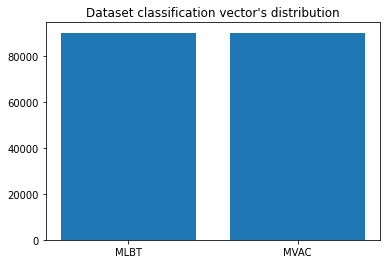


#############################################################
Classification vector statistics:
['MLBT' 'MVAC']
[90000 90000]
['MLBT' 'MVAC']
Sample 20 head labels:
[1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0]
#############################################################



In [ ]:
def plot_y_train_dataset_distribution(y_train):
  unique_class_labels,positions = np.unique(y_train,return_inverse=True)


  counts = np.bincount(positions)
  plt.bar(unique_class_labels, counts)
  plt.title("Dataset classification vector's distribution")
  
  
  file_name='hm_jetscape_ml_plot_y_train_dataset_distribution.png'
  file_path=simulation_directory_path+file_name
  plt.savefig(file_path)

  plt.show()
  plt.close()
  print("\n#############################################################")
  print("Classification vector statistics:")
  print(unique_class_labels)
  unique_class_labels,positions = np.unique(y_train,return_inverse=True)
  print(counts)
  print(unique_class_labels)
  print("Sample 20 head labels:")
  print(positions[:20])
  print("#############################################################\n")

#Checking Train Dataset Y Distribution
plot_y_train_dataset_distribution(y_train)

# Changing classification labels from Literal to Numeric

---



In [ ]:
def convertDatasetYFromLiteralToNumeric(y_dataset):
  y_train=y_dataset[0]
  y_test=y_dataset[1]
  y_train_unique_class_labels,y_train_positions = np.unique(y_train,return_inverse=True)
  y_test_unique_class_labels,y_test_positions = np.unique(y_test,return_inverse=True)
  
  print(y_train_unique_class_labels)
  print(y_test_unique_class_labels)
  
  y_train=y_train_positions
  y_test=y_test_positions
  
  return ((y_train,y_test))


print("\n#############################################################")
print("Changing classification labels from Literal to Numeric:")
print("\nBefore conversion:")
print(type(y_train), y_train.size, y_train.shape)
print(type(y_test), y_test.size, y_test.shape)
print(type(y_train[0]))
print(type(y_test[0]))

y_train,y_test =convertDatasetYFromLiteralToNumeric((y_train,y_test))

print("\nAfter conversion:")
print(type(y_train), y_train.size, y_train.shape)
print(type(y_test), y_test.size, y_test.shape)

print(type(y_train[0]))
print(type(y_test[0]))
print("#############################################################\n")


#############################################################
Changing classification labels from Literal to Numeric:

Before conversion:
<class 'numpy.ndarray'> 180000 (180000,)
<class 'numpy.ndarray'> 20000 (20000,)
<class 'numpy.str_'>
<class 'numpy.str_'>
['MLBT' 'MVAC']
['MLBT' 'MVAC']

After conversion:
<class 'numpy.ndarray'> 180000 (180000,)
<class 'numpy.ndarray'> 20000 (20000,)
<class 'numpy.int64'>
<class 'numpy.int64'>
#############################################################



## Normalizing the Dataset X
For training the model, the dataset needs to be normalized, meaning all of the dataset values should me between zero and one. This can be done by finding the maximum values over the dataset X side values and devide all the element by it.

In [ ]:
def calculate_dataset_x_max_value(x_dataset):
  x_train=x_dataset[0]
  x_test=x_dataset[1]
  max_x=np.amax([np.amax(x_train), np.amax(x_test)])
  return max_x

def normalize_dataset_x_value_range_between_0_and_1(x_dataset,max_x):
  x_train=x_dataset[0]
  x_test=x_dataset[1]

  # Normalize the data to a 0.0 to 1.0 scale for faster processing
  x_train, x_test = x_train / max_x, x_test / max_x
  return (x_train, x_test)


#Normalizing Phase
x_dataset=(x_train,x_test)
max_x=calculate_dataset_x_max_value(x_dataset)
x_train,x_test=normalize_dataset_x_value_range_between_0_and_1(x_dataset,max_x)

image_frame_size=32

print("\n#############################################################")

print("Normalizing Dataset X: maximum sum of transfer momentum in the dataset: ")
print(max_x)

print("#############################################################\n")



#############################################################
Normalizing Dataset X: maximum hit frequency in the dataset: 
20.0
#############################################################



## Defining Validation Dataset from Train Dataset

In [ ]:
# Reserve 20% samples for validation dataset
def calculate_validation_dataset_size(dataset_train_size,dataset_test_size):
  dataset_size= dataset_train_size+dataset_test_size
  dataset_validation_size=dataset_size*.2
  return int(dataset_validation_size)

def set_validation_dataset(x_train,y_train,validation_dataset_size):
  
  x_val = x_train[-validation_dataset_size:]
  y_val = y_train[-validation_dataset_size:]
  x_train = x_train[:-validation_dataset_size]
  y_train = y_train[:-validation_dataset_size]
  
  
  return (x_train, y_train), (x_val, y_val)

validation_dataset_size= calculate_validation_dataset_size(y_train.size,y_test.size)
(x_train, y_train), (x_val, y_val)=set_validation_dataset(x_train,y_train,validation_dataset_size)
print("\n#############################################################")
print("Defining Validation Dataset from Train Dataset:")

print("\nTrain data info:")
print(type(y_train), y_train.size, y_train.shape)
print(type(x_train), x_train.size, x_train.shape)

print("\nValidation data info:")
print(type(y_val), y_val.size, y_val.shape)
print(type(x_val), x_val.size, x_val.shape)

print("\nTest data info:")
print(type(y_test), y_test.size, y_test.shape)
print(type(x_test), x_test.size, x_test.shape)
print("#############################################################\n")


#############################################################
Defining Validation Dataset from Train Dataset:

Train data info:
<class 'numpy.ndarray'> 140000 (140000,)
<class 'numpy.ndarray'> 143360000 (140000, 32, 32)

Validation data info:
<class 'numpy.ndarray'> 40000 (40000,)
<class 'numpy.ndarray'> 40960000 (40000, 32, 32)

Test data info:
<class 'numpy.ndarray'> 20000 (20000,)
<class 'numpy.ndarray'> 20480000 (20000, 32, 32)
#############################################################



## 5.2 Apply Keras/TensorFlow with complicated CNN
Previous research replication


In [ ]:
## event info
collision = 'PbPb'
energy = 5020
centrality = '0_10'
Modules = ['MATTER','LBT']
JetptMinMax = '100_110'
#observables = ['pt','charge','mass']
observables = ['pt']
kind = 'Hadron'

In [ ]:
## create a directory to save the best model

save_dir = (simulation_directory_path+'Models_{}_vs_{}_{}_ch{}').format(Modules[0], Modules[1], kind, len(observables))
if not path.exists(save_dir):
    makedirs(save_dir)
print('Directory to save models: {}'.format(save_dir))

Directory to save models: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/models/Models_PP19_vs_LBT_Hadron_ch1


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad


def get_callbacks(monitor, save_dir):
    mode = None
    if 'loss' in monitor:
        mode = 'min'
    elif 'accuracy' in monitor:
        mode = 'max'
    assert mode != None, 'Check the monitor parameter!'

    es = EarlyStopping(monitor=monitor, mode=mode, patience=10,
                      min_delta=0., verbose=1)
    rlp = ReduceLROnPlateau(monitor=monitor, mode=mode, factor=0.2, patience=5,
                            min_lr=0.001, verbose=1)
    mcp = ModelCheckpoint(path.join(save_dir, 'hm_jetscape_ml_model_best.h5'), monitor=monitor, 
                          save_best_only=True, mode=mode, verbose=1)
    
    return [es, rlp, mcp]

def conv2d_layer_block(prev_layer, filters, dropout_rate, input_shape=None):
    if input_shape != None:
        prev_layer.add(Conv2D(filters=filters, kernel_size=5,
                              kernel_initializer='he_uniform',
                              padding='same',
                              activation='relu',
                              kernel_regularizer=l2(l=0.02),
                              input_shape=input_shape
                             )
                      )
    else:
        prev_layer.add(Conv2D(filters=filters, kernel_size=5,
                              kernel_initializer='he_uniform',
                              padding='same',
                              activation='relu',
                              kernel_regularizer=l2(l=0.02),
                             )
                      )
    prev_layer.add(Conv2D(filters=filters, kernel_size=5,
                              kernel_initializer='he_uniform',
                              padding='same',
                              activation='relu',
                              kernel_regularizer=l2(l=0.02)
                             )
                      )    
    prev_layer.add(MaxPool2D(pool_size=(2, 2)))
    prev_layer.add(Dropout(dropout_rate))
    
    return prev_layer

def fc_layer_block(prev_layer, units, dropout_rate, last_layer=False):
    if last_layer == False:
        prev_layer.add(Dense(units, activation='relu',
                             kernel_initializer='he_uniform',
                             kernel_regularizer=l2(l=0.02)
                            )
                      )
        prev_layer.add(Dropout(dropout_rate))
    else:
        prev_layer.add(Dense(1, activation='sigmoid'))

    return prev_layer

def CNN_model(input_shape, lr, dropout1, dropout2):
    model = Sequential()
    model = conv2d_layer_block(model, 256, dropout1, input_shape)
    model = conv2d_layer_block(model, 256, dropout1)
    model = conv2d_layer_block(model, 256, dropout1)
    model = conv2d_layer_block(model, 256, dropout1)
    #model = conv2d_layer_block(model, 128, dropout1)
    model.add(Flatten())
    model = fc_layer_block(model, 1024, dropout2)
    model = fc_layer_block(model, 1024, dropout2)
    model = fc_layer_block(model, 1024, dropout2)
    model = fc_layer_block(model, 1024, dropout2)
    model = fc_layer_block(model, 1, None, last_layer=True)
    
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

In [ ]:
print("\n#############################################################")
print("Reshaping dataset X-side dimension to be fit in the defined convolutional :")

print("\nX train:")
print(x_train.shape)
print (x_train.shape[0],x_train.shape[1],x_train.shape[2])
x_train_reshaped=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
print(x_train_reshaped.shape)

print("\nX val:")
print(x_val.shape)
print (x_val.shape[0],x_val.shape[1],x_val.shape[2])
x_val_reshaped=x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)
print(x_train_reshaped.shape)

print("\nX test:")
print(x_test.shape)
print (x_test.shape[0],x_test.shape[1],x_test.shape[2])
x_test_reshaped=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
print(x_test_reshaped.shape)
print("#############################################################\n")



#############################################################
Reshaping dataset X-side dimention to be fit in the defined convolutional :
X train:
(140000, 32, 32)
140000 32 32
(140000, 32, 32, 1)
X val:
(40000, 32, 32)
40000 32 32
(140000, 32, 32, 1)
X test:
(20000, 32, 32)
20000 32 32
(20000, 32, 32, 1)
#############################################################



In [ ]:
## parameers for training
n_epochs = 50
# n_epochs=2
batch_size = 256
input_shape = x_train_reshaped.shape[1:]
monitor='val_accuracy' #'val_accuracy' or 'val_loss'
lr = 5e-6
dropout1, dropout2 = 0.2, 0.2

In [ ]:
from time import time
def train_network(train_set, val_set, n_epochs, lr, batch_size, monitor):
    tf.keras.backend.clear_session()
    X_train = train_set[0]
    Y_train = train_set[1]
    model = CNN_model(input_shape, lr, dropout1, dropout2)
    callbacks = get_callbacks(monitor, save_dir)
    
    model.summary()
    
    start = time()
    history = model.fit(X_train, Y_train, epochs=n_epochs, verbose=1, batch_size=batch_size, 
                        validation_data=val_set, shuffle=True, callbacks=callbacks)
    train_time = (time()-start)/60.
    return history, train_time

In [ ]:
# training and validation sets
train_set, val_set = (x_train_reshaped, y_train), (x_val_reshaped, y_val)

# train the network
history, train_time = train_network(train_set, val_set, n_epochs, lr, batch_size, monitor)
file_name='hm_jetscape_ml_model_history.csv'
file_path=simulation_directory_path+file_name
pd.DataFrame.from_dict(history.history).to_csv(file_path,index=False)


file_name='hm_jetscape_ml_model_history.npy'
file_path=simulation_directory_path+file_name
np.save(file_path,history.history)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       6656      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       1638656   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       1638656   
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       1638656   
                                                        

In [ ]:
# This section shall be just used after training or for stand alone evaluations
# Building a dictionary which is accessable by dot
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

#Loading learning history after training 
file_name='hm_jetscape_ml_model_history.npy'
file_path=simulation_directory_path+file_name


history=dict({'history':np.load(file_path,allow_pickle='TRUE').item()})
history=dotdict(history)
print(history)

{'history': {'loss': [228.9948661621094, 197.9379549281529], 'accuracy': [0.50295, 0.51447856], 'val_loss': [212.5898095703125, 183.9870919433594], 'val_accuracy': [0.559325, 0.529875], 'lr': [5e-06, 5e-06]}}


In [ ]:
from matplotlib import pyplot as plt
def plot_train_history(history):

    color_list = ['red','blue','black','green']

    plt.figure(figsize=(8, 2.5), dpi=100)

    plt.subplot(121)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.title('Loss history')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy history')
    plt.legend()
    file_name='hm_jetscape_ml_plot_train_history.png'
    file_path=simulation_directory_path+file_name
    plt.savefig(file_path)
    plt.show()
    plt.close()
# plot the training history for each fold
plot_train_history(history)

In [ ]:
from tensorflow.keras.models import load_model
## load the best model
best_model = load_model(path.join(save_dir,'hm_jetscape_ml_model_best.h5'))

outputStr='Train   | Validation | Test sets\n'

## evaluate the model on train/val/test sets and append the results to lists
_, train_acc = best_model.evaluate(x_train_reshaped, y_train, verbose=0)
_, val_acc = best_model.evaluate(x_val_reshaped, y_val, verbose=0)
_, test_acc = best_model.evaluate(x_test_reshaped, y_test, verbose=0)
    
## print out the accuracy
outputStr+='{:.4f}%  {:.4f}%     {:.4f}%\n'.format(train_acc * 100, val_acc * 100, test_acc * 100)
print(outputStr)

file_name="hm_jetscape_ml_model_evaluation.txt"
file_path=simulation_directory_path+file_name
evaluation_file = open(file_path, "w")
evaluation_file.write(outputStr)
evaluation_file.close()


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
## plot confution matrix
y_pred = best_model.predict_classes(x_test_reshaped)

conf_mat = confusion_matrix(y_pred, y_test)
sns.heatmap(conf_mat, annot=True, cmap='Blues', 
            xticklabels=Modules, yticklabels=Modules, fmt='g')
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Prediction', fontsize=15)
file_name='hm_jetscape_ml_model_confision_matrix.png'
file_path=simulation_directory_path+file_name
plt.savefig(file_path)
plt.show()
plt.close()

classification_report_str= classification_report(y_test,y_pred)

print (classification_report_str)
file_name="hm_jetscape_ml_model_evaluation.txt"
file_path=simulation_directory_path+file_name
evaluation_file = open(file_path, "a")
evaluation_file.write(classification_report_str)
evaluation_file.close()

AttributeError: ignored

#Binary Classification Results


Classification                      | #epoch | Hadron \begin{pmatrix} p_{T} \end{pmatrix}
-------------------                 |--------|------------------
MATTER (in-medium) v.s. MATTER+LBT  |500| 95.88%
 

#Precision - Recall - F1Score

$precision= \frac{true \: positive}{true \: positive \: + \:false \: positive}$

$recal= \frac{true \: positive}{true \: positive \: + \: false \: negative}$

$f1-score= \frac{2}{precision^{-1} \: + \: recall^{-1}}$

In [ ]:

# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [ ]:
def calcualte_precision_recall_f1score_confision_matrix():
  prediction=model.predict(x_test)
  prediction=[ 1 if current_y_test>0.5 else 0 for current_y_test in prediction ]
  #checking if prediction vector is binary
  truth=y_test
  cm = confusion_matrix(truth,prediction)
  print_confusion_matrix(cm,["MATTER","MATTER-LBT"])
  print(classification_report(truth, prediction))

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good.  However, beyond this, there is not much more you can determine.  Low MSE values are desired.

$ \mbox{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $


In [ ]:
from sklearn import metrics
def calcualte_mse(x_test):

  # Predict
  pred = model.predict(x_test)
  # Measure MSE error.  
  mse = metrics.mean_squared_error(pred,y_test)
  print("Final score (MSE): {}".format(mse))
  rmse = np.sqrt(mse)
  print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))


Final score (MSE): 0.3986714993310698
Root Mean Square Error on test set: 0.631
